# Competition Objective

Elo, one of the largest payment brands in Brazil, has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signal in customer loyalty.

# Objective of the Notebook
Objevtive of the notebook is to explore the given data and get some interesting insights which will help in our model building process.

In [1]:
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

# Dataset Exploration
In this part, let us look at the given files before we get into data exploration.

In [2]:
ls

 Volume in drive C is OS
 Volume Serial Number is E076-E8E0

 Directory of C:\Users\Martin\Desktop\Kaggle\Regressions\Elo Merchant Category Recommendation\all

12/11/2018  06:46 PM    <DIR>          .
12/11/2018  06:46 PM    <DIR>          ..
12/11/2018  06:39 PM    <DIR>          .ipynb_checkpoints
12/11/2018  06:15 PM         4,583,560 baseline_lgb.csv
12/11/2018  02:45 PM            17,600 Data_Dictionary.xlsx
12/11/2018  06:27 PM           474,992 E.D.A and Baseline.ipynb
12/11/2018  02:46 PM     2,845,920,484 historical_transactions.csv
12/11/2018  06:46 PM           475,113 LGBM.ipynb
12/11/2018  02:45 PM        50,040,976 merchants.csv
12/11/2018  02:45 PM       190,246,145 new_merchant_transactions.csv
12/11/2018  02:45 PM         2,225,229 sample_submission.csv
12/11/2018  02:45 PM         3,708,740 test.csv
12/11/2018  02:45 PM         8,383,651 train.csv
              10 File(s)  3,106,076,490 bytes
               3 Dir(s)  37,751,005,184 bytes free


So we are given the above files. The description of the files are

* train.csv - the training set
* test.csv - the test set
* sample_submission.csv - a sample submission file in the correct format - contains all card_ids you are expected to predict for.
* historical_transactions.csv - up to 3 months' worth of historical transactions for each card_id
* merchants.csv - additional information about all merchants / merchant_ids in the dataset.
* new_merchant_transactions.csv - two months' worth of data for each card_id containing ALL purchases that card_id made at merchant_ids that were not visited in the historical data.
* First let us explore the train and test set.

In [3]:
train_df = pd.read_csv('train.csv', parse_dates=['first_active_month'])
test_df = pd.read_csv('test.csv', parse_dates=['first_active_month'])
print("Number of rows and columns in train set : ",train_df.shape)
print("Number of rows and columns in test set : ",test_df.shape)

Number of rows and columns in train set :  (201917, 6)
Number of rows and columns in test set :  (123623, 5)


In [4]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


# Target Column Exploration:
In this section, let us explore the target column

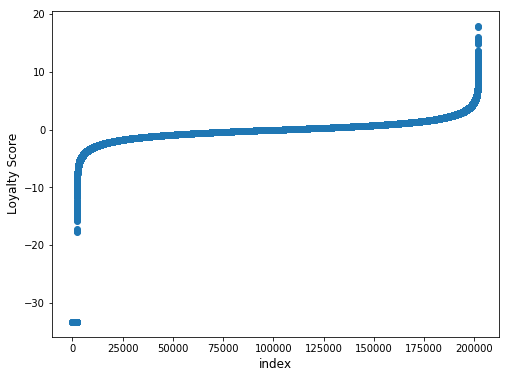

In [5]:
target_col = 'target'

plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df[target_col].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.show()

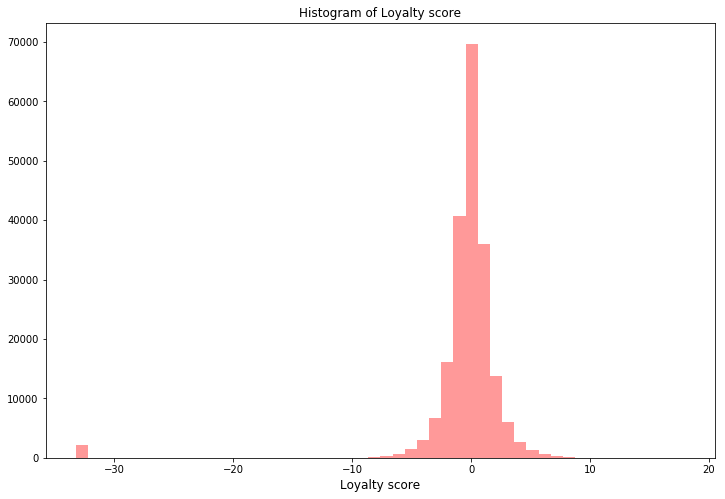

In [6]:
plt.figure(figsize=(12,8))
sns.distplot(train_df[target_col].values, bins=50, kde=False, color='red')
plt.title('Histogram of Loyalty score')
plt.xlabel('Loyalty score', fontsize=12)
plt.show()

We can see that some of the loyalty value are apart (less than -30) compared to others. Let us just get their count.

In [7]:
train_df[train_df[target_col]<-30].shape[0]

2207

We have 2207 rows (almost 1% of the data), which has values different from the rest. Since the metric RMSE these rows might play an important role. So bewere of them.

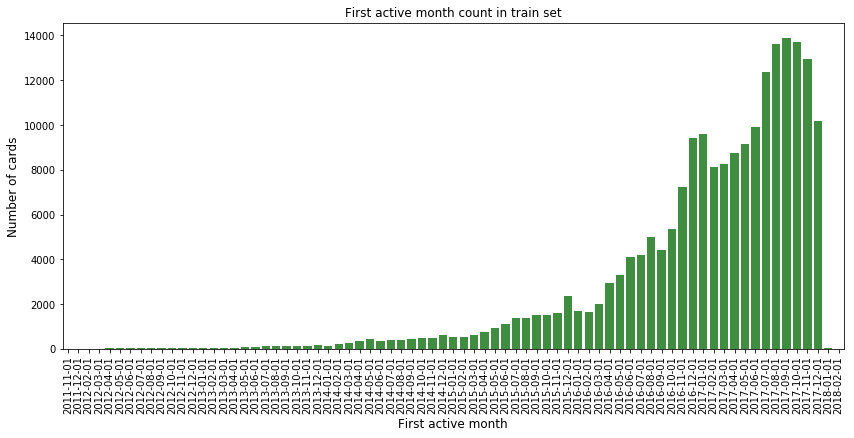

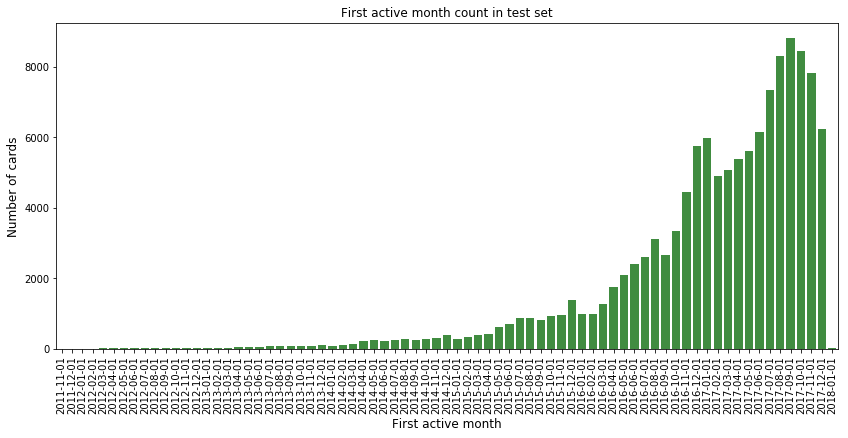

In [8]:
cnt_srs = train_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in train set")
plt.show()

cnt_srs = test_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in test set")
plt.show()

Looks like the distribution is kind similar between train an test set. So we need not really have to do time based split i think.

# Feature 1,2 & 3:

In this section. let us see if the other variables in the train dataset has a good predictive power in finding the loyalty score.

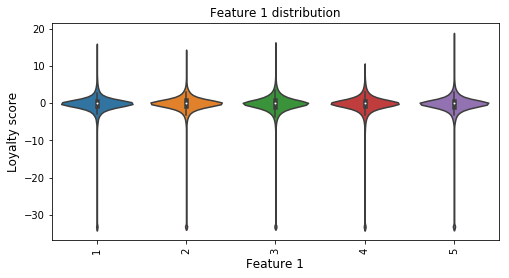

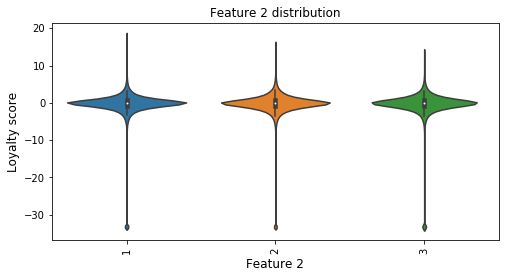

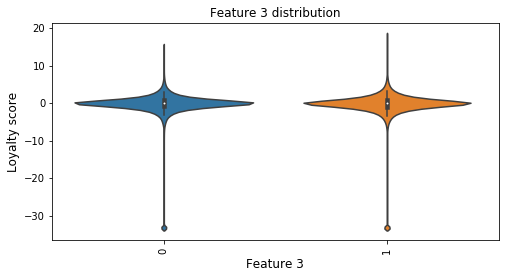

In [9]:
#feature 1
plt.figure(figsize=(8,4))
sns.violinplot(x='feature_1', y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 1 distribution")
plt.show()

#feature 2
plt.figure(figsize=(8,4))
sns.violinplot(x='feature_2', y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 2', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 2 distribution")
plt.show()

#feature 3
plt.figure(figsize=(8,4))
sns.violinplot(x='feature_3', y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 3', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 3 distribution")
plt.show()

Tp the naked eyes, the distribution of the different caregories in all three feature look kind of similar. May be the models are able to find something here.

# Historical Transacions:
Now let us look at the historical transactions data for the cards.

In [10]:
hist_df = pd.read_csv('historical_transactions.csv')
hist_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


The field descriptions are as follows:

* card_id - Card identifier
* month_lag - month lag to reference date
* purchase_date - Purchase date
* authorized_flag - 'Y' if approved, 'N' if denied
* category_3 - anonymized category
* installments - number of installments of purchase
* category_1 - anonymized category
* merchant_category_id - Merchant category identifier (anonymized )
* subsector_id - Merchant category group identifier (anonymized )
* merchant_id - Merchant identifier (anonymized)
* purchase_amount - Normalized purchase amount
* city_id - City identifier (anonymized )
* state_id - State identifier (anonymized )
* category_2 - anonymized category

Now let us make some features based on the historical transactions and merge them with train and test set.

# Number of Historical Transactions of the card

In [11]:
gdf = hist_df.groupby('card_id')
gdf = gdf['purchase_amount'].size().reset_index()
gdf.columns = ['card_id', 'num_hist_transactions']
train_df = pd.merge(train_df, gdf, on='card_id',how='left')
test_df = pd.merge(test_df, gdf, on='card_id', how='left')

In [12]:
cnt_srs = train_df.groupby('num_hist_transactions')[target_col].mean()
cnt_srs = cnt_srs.sort_index()
cnt_srs = cnt_srs[:-50]

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
    x=cnt_srs.index[::-1],
    y=cnt_srs.values[::-1],
    showlegend=False,
    marker=dict(color=color,),)
    return trace

trace = scatter_plot(cnt_srs, 'orange')
layout = dict(title='Loyalty score by Number of historical transactions')
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Histtranscnt')

Now let us bin the count of historical transactions and then do some box plots to see the plots better.

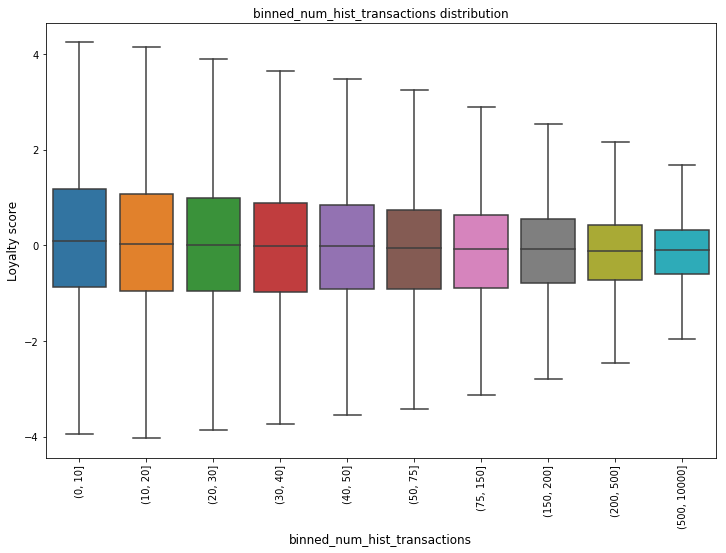

In [13]:
bins = [0, 10, 20, 30, 40, 50, 75, 150, 200, 500, 10000]
train_df['binned_num_hist_transactions'] = pd.cut(train_df['num_hist_transactions'], bins)
cnt_srs = train_df.groupby('binned_num_hist_transactions')[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x='binned_num_hist_transactions',y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_num_hist_transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title('binned_num_hist_transactions distribution')
plt.show()

# Value of Historical Transactions
Now let us check the value of the historical transactions for the cards and check the loyalty score distribution based on that.

In [14]:
gdf = hist_df.groupby('card_id')['purchase_amount'].agg(['sum','mean','std','min','max']).reset_index()
gdf.columns = ['card_id','sum_hist_trans','mean_hist_trans','std_hist_trans','min_hist_trans','max_hist_trans']
train_df = pd.merge(train_df, gdf, on='card_id', how='left')
test_df = pd.merge(test_df,gdf, on='card_id', how='left')

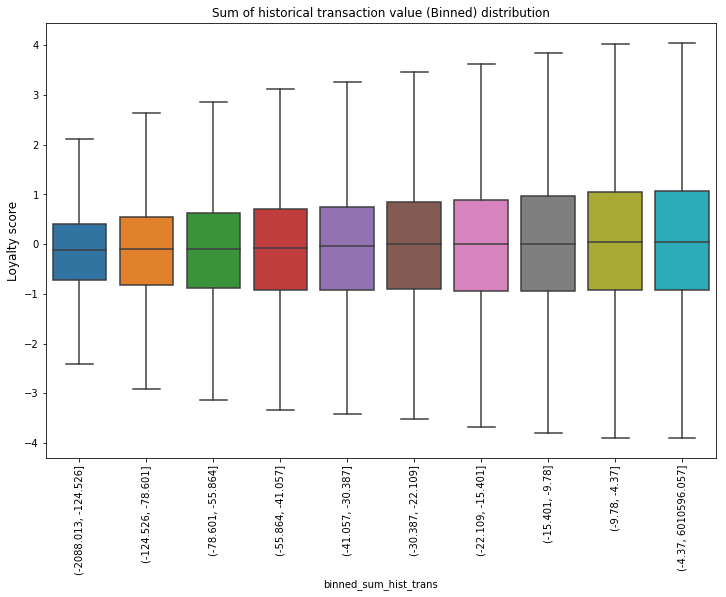

In [15]:
bins = np.percentile(train_df['sum_hist_trans'], range(0,101,10))
train_df['binned_sum_hist_trans'] = pd.cut(train_df['sum_hist_trans'], bins)

plt.figure(figsize=(12,8))
sns.boxplot(x='binned_sum_hist_trans', y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_sum_hist_trans')
plt.ylabel('Loyalty score', fontsize=12)
plt.title('Sum of historical transaction value (Binned) distribution')
plt.show()

As we could see, the loyalty score seem to increase with the "sum of historical transaction value". This is expected.
Now we can do the same plot with "Mean value of historical transaction"

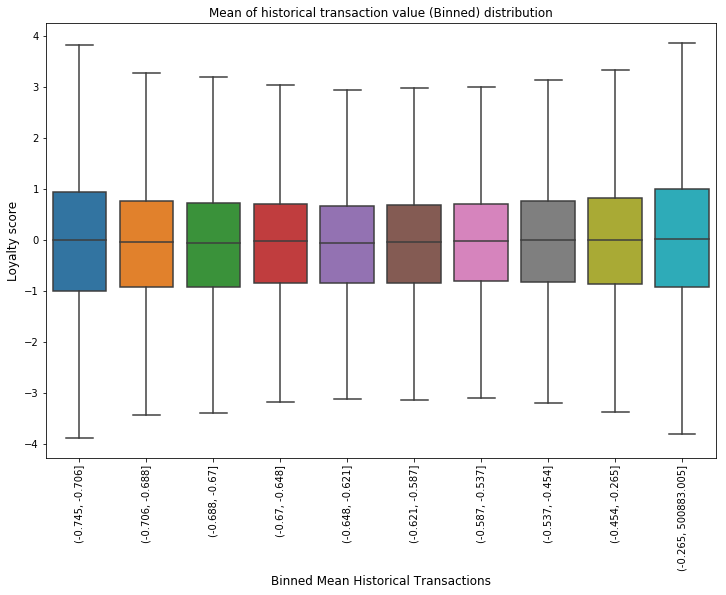

In [16]:
bins = np.percentile(train_df['mean_hist_trans'], range(0,101,10))
train_df['binned_mean_hist_trans'] = pd.cut(train_df['mean_hist_trans'], bins)

plt.figure(figsize=(12,8))
sns.boxplot(x='binned_mean_hist_trans', y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('Binned Mean Historical Transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Mean of historical transaction value (Binned) distribution")
plt.show()

# New Merchant Transactions
In this section, let us look at the new merchant transaction data and do some analysis

In [17]:
new_trans_df = pd.read_csv('new_merchant_transactions.csv')
new_trans_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [18]:
gdf = new_trans_df.groupby('card_id')['purchase_amount'].size().reset_index()
gdf.columns = ['card_id', 'num_merch_transactions']
train_df = pd.merge(train_df, gdf, on='card_id', how='left')
test_df = pd.merge(test_df, gdf, on='card_id', how='left')

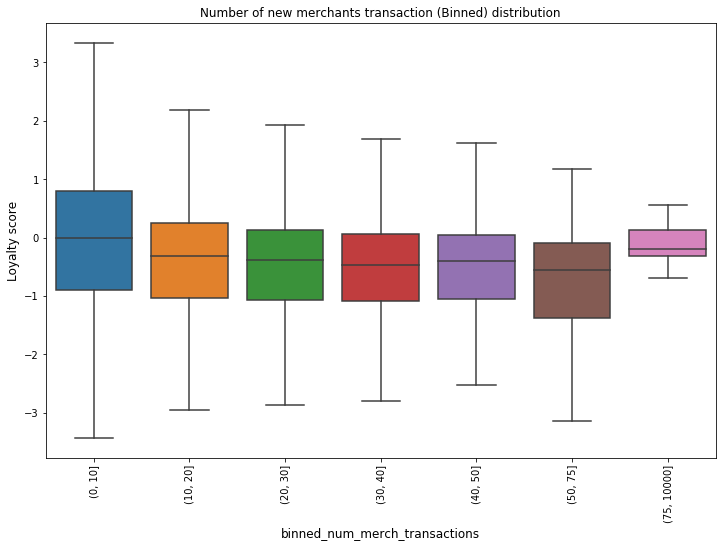

In [19]:
bins = [0, 10, 20, 30, 40, 50, 75, 10000]
train_df['binned_num_merch_transactions'] = pd.cut(train_df['num_merch_transactions'], bins)
cnt_srs = train_df.groupby("binned_num_merch_transactions")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_num_merch_transactions", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_num_merch_transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Number of new merchants transaction (Binned) distribution")
plt.show()

Loyalty score seem to decrease as the number of new merchant transactions increases except for the last bin.

In [20]:
gdf = new_trans_df.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ["card_id", "sum_merch_trans", "mean_merch_trans", "std_merch_trans", "min_merch_trans", "max_merch_trans"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

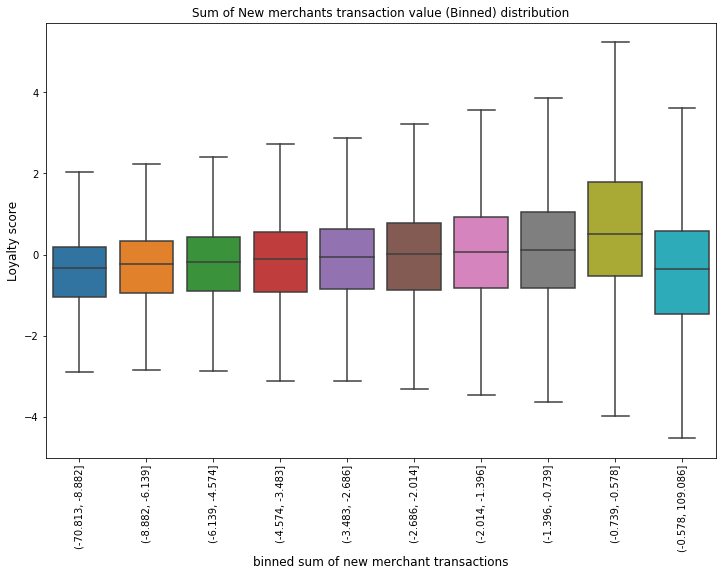

In [21]:
bins = np.nanpercentile(train_df["sum_merch_trans"], range(0,101,10))
train_df['binned_sum_merch_trans'] = pd.cut(train_df['sum_merch_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_sum_merch_trans", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned sum of new merchant transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Sum of New merchants transaction value (Binned) distribution")
plt.show()

Loyalty scores seem to increase with the increase in the sum of new merchant transaction values but for the last bin.

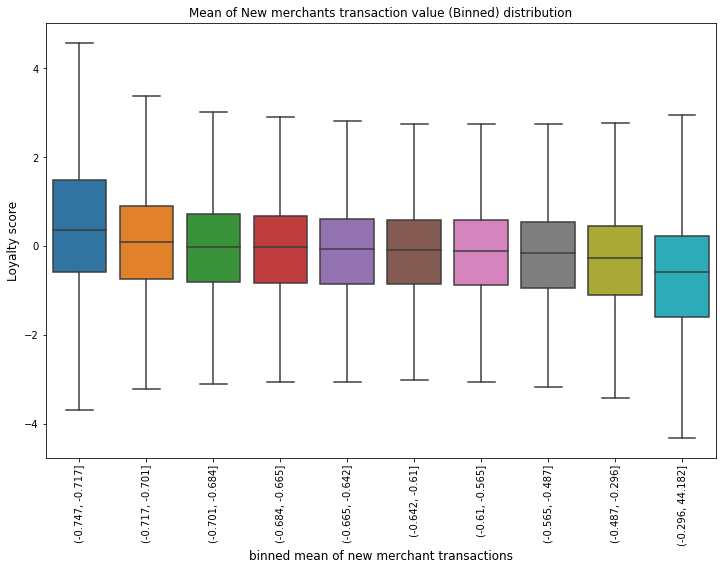

In [22]:
bins = np.nanpercentile(train_df["mean_merch_trans"], range(0,101,10))
train_df['binned_mean_merch_trans'] = pd.cut(train_df['mean_merch_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_mean_merch_trans", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned mean of new merchant transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Mean of New merchants transaction value (Binned) distribution")
plt.show()

# Baseline Model
Let us build a baseline model using the features creates so far.

In [23]:
train_df['year'] = train_df['first_active_month'].dt.year
test_df['year'] = test_df['first_active_month'].dt.year
train_df['month'] = train_df['first_active_month'].dt.month
test_df['month'] = test_df['first_active_month'].dt.month

cols_to_use = ["feature_1", "feature_2", "feature_3", "year", "month", 
               "num_hist_transactions", "sum_hist_trans", "mean_hist_trans", "std_hist_trans", 
               "min_hist_trans", "max_hist_trans",
               "num_merch_transactions", "sum_merch_trans", "mean_merch_trans", "std_merch_trans",
               "min_merch_trans", "max_merch_trans",
              ]

def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {'num_leaves': 129,
         'min_data_in_leaf': 148, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "min_child_samples": 24,
         "boosting": "gbdt",
         "feature_fraction": 0.7202,
         "bagging_freq": 1,
         "bagging_fraction": 0.8125 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.3468,
         "random_state": 133,
         "verbosity": -1
             }
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgtrain,lgval],
                     early_stopping_rounds=100, verbose_eval=100, evals_result = evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

train_X = train_df[cols_to_use]
test_X = test_df[cols_to_use]
train_y = train_df[target_col].values

pred_test = 0
kf = model_selection.KFold(n_splits=5, random_state=2018, shuffle=True)
for dev_index, val_index in kf.split(train_df):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    pred_test_tmp, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test += pred_test_tmp/kf.n_splits
    

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.80988	valid_1's rmse: 3.83115
[200]	training's rmse: 3.78565	valid_1's rmse: 3.81937
[300]	training's rmse: 3.76838	valid_1's rmse: 3.81366
[400]	training's rmse: 3.75547	valid_1's rmse: 3.81088
[500]	training's rmse: 3.74491	valid_1's rmse: 3.80946
[600]	training's rmse: 3.73588	valid_1's rmse: 3.80863
[700]	training's rmse: 3.72807	valid_1's rmse: 3.8082
[800]	training's rmse: 3.72124	valid_1's rmse: 3.80796
[900]	training's rmse: 3.71493	valid_1's rmse: 3.80787
Early stopping, best iteration is:
[875]	training's rmse: 3.71645	valid_1's rmse: 3.80784
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.82319	valid_1's rmse: 3.7793
[200]	training's rmse: 3.79926	valid_1's rmse: 3.76734
[300]	training's rmse: 3.78244	valid_1's rmse: 3.7615
[400]	training's rmse: 3.76962	valid_1's rmse: 3.75878
[500]	training's rmse: 3.75904	valid_1's rmse: 3.75715
[600]	training's 

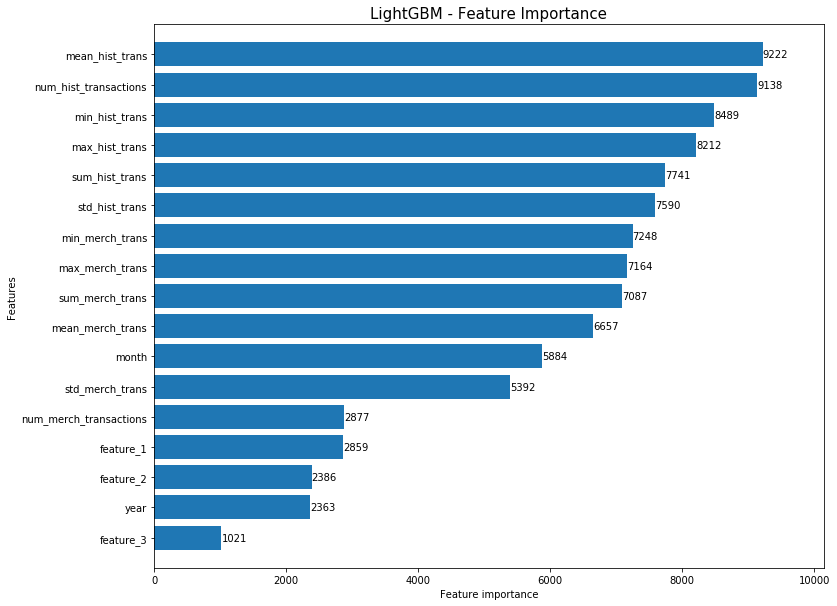

In [24]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [25]:
sub_df = pd.DataFrame({'card_id':test_df['card_id'].values})
sub_df['target'] = pred_test
sub_df.to_csv("baseline_lgb.csv",index=False)